In [1]:
from datasets.socofing import SOCOFingGender, SOCOFingFingers, SOCOFingSubjects
import numpy as np
from matplotlib import pyplot as plt
from keras import layers, Sequential, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


In [5]:
SOCOGender = SOCOFingGender()
SOCOSubjects = SOCOFingSubjects()
SOCOFingers = SOCOFingFingers()

genderDSs = SOCOGender.createDatasets()
objectsDSs = SOCOSubjects.createDatasets()
fingersDSs = SOCOFingers.createDatasets()

create 'SOCOFingGender - train' dataset with 1700 samples.
create 'SOCOFingGender - test' dataset with 380 samples.
create 'SOCOFingGender - validation' dataset with 380 samples.
create 'SOCOFingSubjects - train' dataset with 1700 samples.
create 'SOCOFingSubjects - test' dataset with 380 samples.
create 'SOCOFingSubjects - validation' dataset with 380 samples.
create 'SOCOFingFingers - train' dataset with 1700 samples.
create 'SOCOFingFingers - test' dataset with 380 samples.
create 'SOCOFingFingers - validation' dataset with 380 samples.


In [6]:
def display_images_from_dataset(dataset, title='', numOfImages=9):
  plt.figure(figsize=(13,13))
  plt.suptitle(title)
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.title(str(label.numpy()) + " " +str(image.numpy().shape), fontsize=16)
    subplot += 1
    if i==numOfImages-1:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

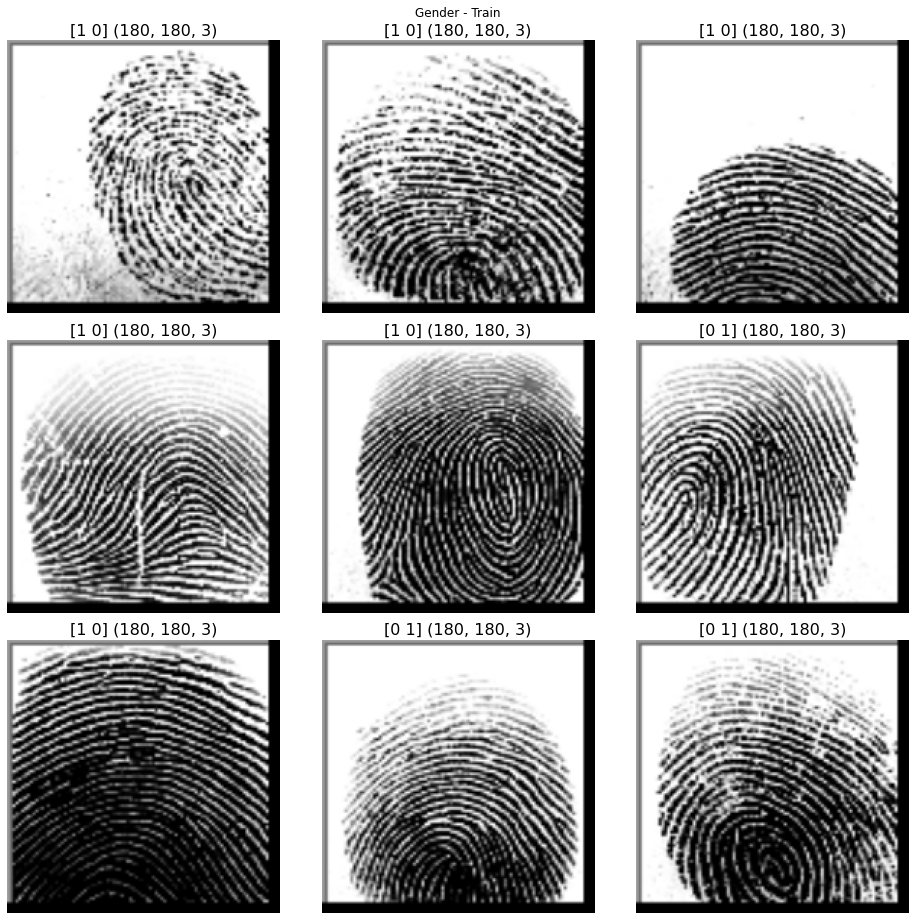

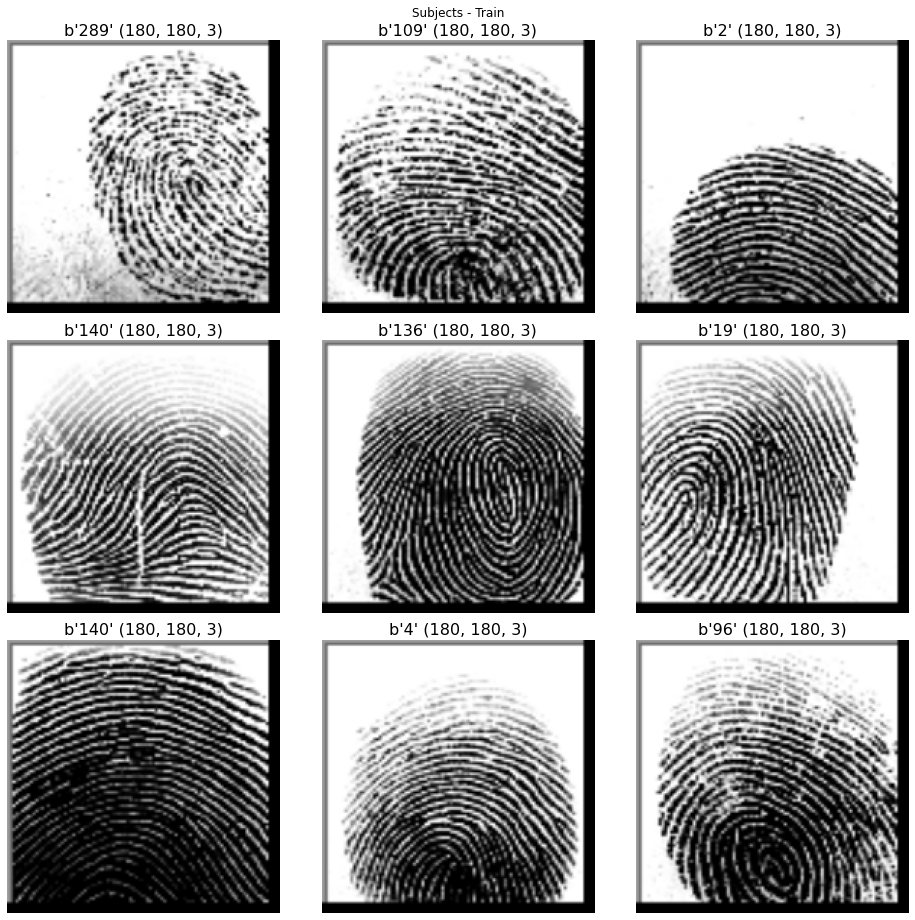

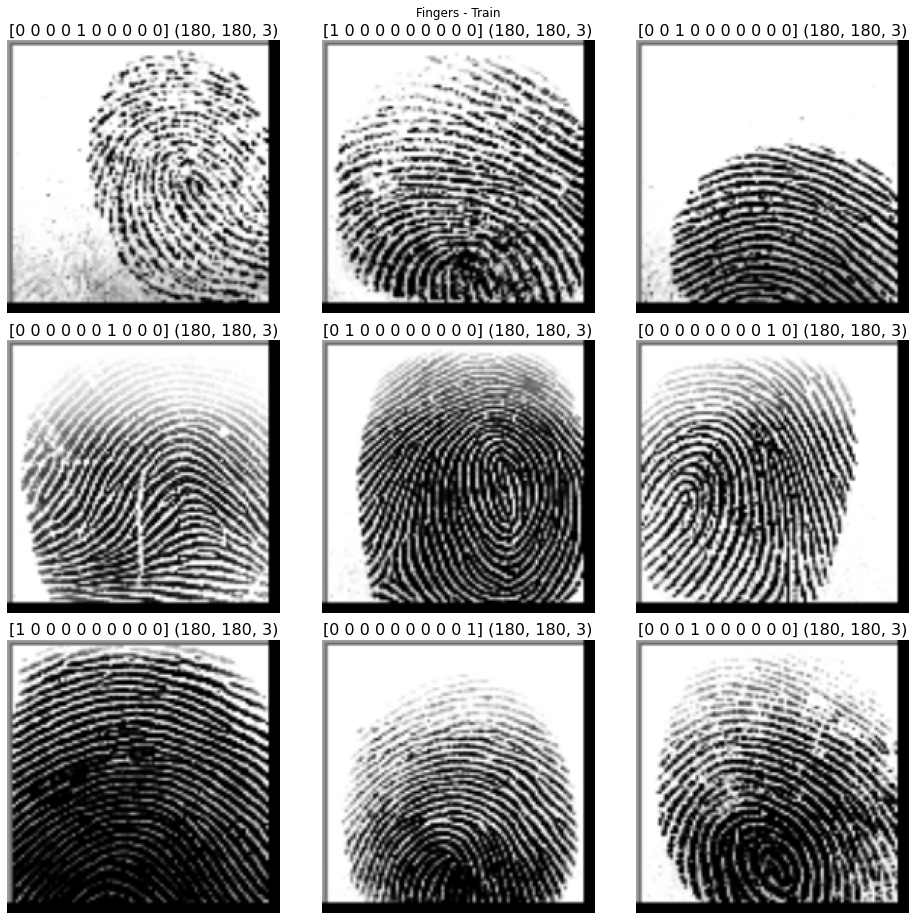

In [7]:
display_images_from_dataset(genderDSs[0], 'Gender - Train')
display_images_from_dataset(objectsDSs[0], 'Subjects - Train')
display_images_from_dataset(fingersDSs[0], 'Fingers - Train')

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

PATH = './data/socofing/{}/*.BMP'
TRAIN_PATH = PATH.format("train")
TEST_PATH = PATH.format("test")
VAL_PATH = PATH.format("validation")
CLASSES = {'M': 'male', 'F': 'female'}
class_names = ['F', 'M']

# Fixed seed for split, shuffle and init
seed=9
# image height and width by avvrage dataset size
batch_size = 32
img_dim = (180, 180, 3)
img_height, img_width, img_channels = img_dim

# model hyperparameters
learning_rate = 0.001
epochs_find_best = 10
epochs_best = 100


print(img_dim)
print(img_height, img_width, img_channels)


(180, 180, 3)
180 180 3


In [3]:
def display_images_from_dataset(dataset, title='', numOfImages=9):
  plt.figure(figsize=(13,13))
  plt.title(title)
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.title(str(label.numpy()) + " " +str(image.numpy().shape), fontsize=16)
    subplot += 1
    if i==numOfImages-1:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

create 'socofing - train' dataset with 1700 samples.
create 'socofing - test' dataset with 380 samples.
create 'socofing - validation' dataset with 380 samples.


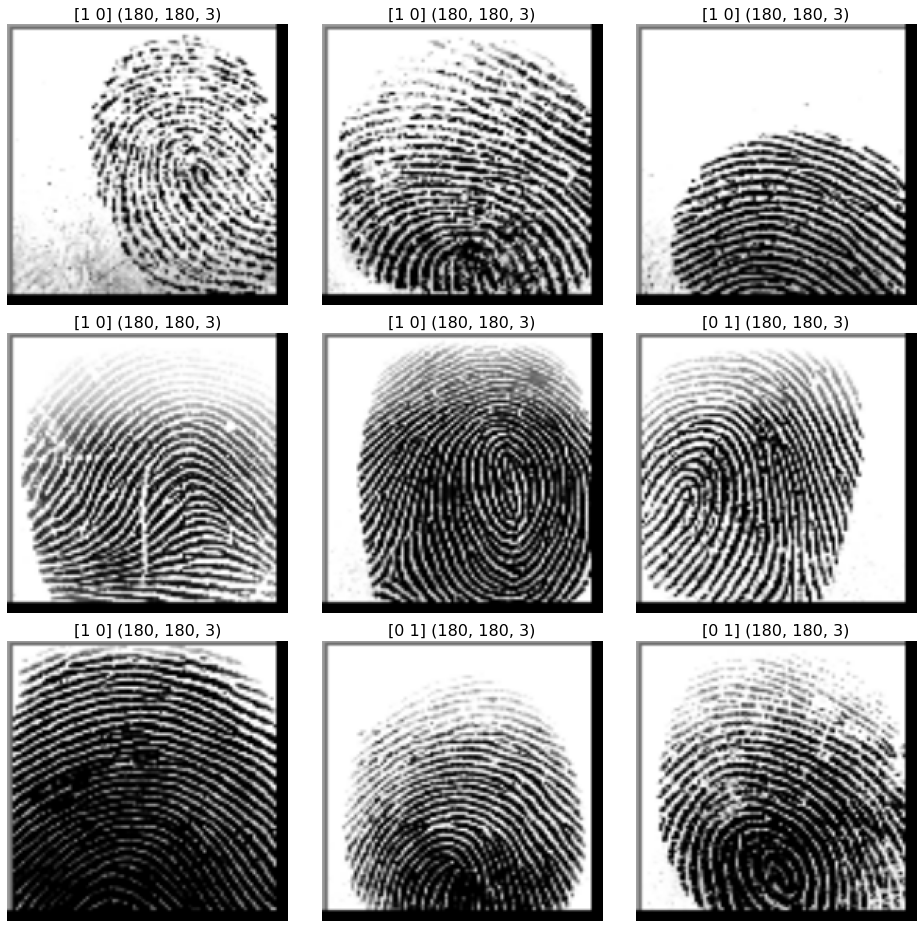

<ParallelMapDataset shapes: ((180, 180, 3), (2,)), types: (tf.uint8, tf.int8)>
<ParallelMapDataset shapes: ((180, 180, 3), (2,)), types: (tf.uint8, tf.int8)>
<ParallelMapDataset shapes: ((180, 180, 3), (2,)), types: (tf.uint8, tf.int8)>


In [16]:
ds = FPDataset('socofing', path='./data/socofing', fileFormat='BMP', dims=img_dim, class_names=class_names)
train_ds, test_ds, val_ds = ds.createDatasets()

display_images_from_dataset(train_ds)

print(train_ds, test_ds, val_ds, sep='\n')

In [21]:
for image, label in train_ds.take(5):
    imageShape = image.numpy().shape
    label = label.numpy()
    labelName = class_names[np.argmax(label)]
    print('Image Shape: {}, Label: {}, LabelName: {}'.format(imageShape, label, labelName))


Image Shape: (180, 180, 3), Label: [1 0], LabelName: F
Image Shape: (180, 180, 3), Label: [0 1], LabelName: M
Image Shape: (180, 180, 3), Label: [0 1], LabelName: M
Image Shape: (180, 180, 3), Label: [1 0], LabelName: F
Image Shape: (180, 180, 3), Label: [0 1], LabelName: M


### Classification Layers ###

Set and initialize a classifier for five classes using fully connected layers, ReLu activation function and Dropout to increase regularization

In [5]:
fc_classifier = Sequential()
fc_classifier.add(layers.Flatten())
fc_classifier.add(layers.Dense(512, activation='relu'))
fc_classifier.add(layers.Dropout(0.4))
fc_classifier.add(layers.Dense(256, activation='relu'))
fc_classifier.add(layers.Dropout(0.3))
fc_classifier.add(layers.Dense(64, activation='relu'))
fc_classifier.add(layers.Dropout(0.2))
fc_classifier.add(layers.Dense(2, activation='softmax'))

In [7]:
ResNet50 = Sequential(
    tf.keras.applications.ResNet50(include_top=False, input_shape=img_dim, pooling='max',classes=len(class_names), weights='imagenet')
    )
for layer in ResNet50.layers:
        layer.trainable=False

classifier = models.clone_model(fc_classifier)
classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
ResNet50.add(classifier)
ResNet50.build((None, img_height, img_width, img_channels))
ResNet50.summary()
ResNet50.compile(optimizer=Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])

ResNet50_history = ResNet50.fit(train_ds, validation_data=val_ds, epochs=epochs_find_best)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 sequential (Sequential)     (None, 2)                 1196994   
                                                                 
Total params: 24,784,706
Trainable params: 1,196,994
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10


2022-04-04 17:00:34.552827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 1.4005 - accuracy: 0.5353

2022-04-04 17:00:46.309463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 16s 209ms/step - loss: 1.4005 - accuracy: 0.5353 - val_loss: 0.6608 - val_accuracy: 0.6474
Epoch 2/10
54/54 [==============================] - 8s 153ms/step - loss: 0.7700 - accuracy: 0.6035 - val_loss: 0.6668 - val_accuracy: 0.6316
Epoch 3/10
54/54 [==============================] - 8s 153ms/step - loss: 0.6989 - accuracy: 0.6018 - val_loss: 0.6283 - val_accuracy: 0.6816
Epoch 4/10
54/54 [==============================] - 8s 154ms/step - loss: 0.6587 - accuracy: 0.6459 - val_loss: 0.6186 - val_accuracy: 0.6684
Epoch 5/10
54/54 [==============================] - 8s 154ms/step - loss: 0.6204 - accuracy: 0.6653 - val_loss: 0.6110 - val_accuracy: 0.6816
Epoch 6/10
54/54 [==============================] - 8s 154ms/step - loss: 0.6130 - accuracy: 0.6794 - val_loss: 0.6314 - val_accuracy: 0.6342
Epoch 7/10
54/54 [==============================] - 8s 154ms/step - loss: 0.5931 - accuracy: 0.6841 - val_loss: 0.5933 - val_accuracy: 0.6789
Epoch 8/10
54/54

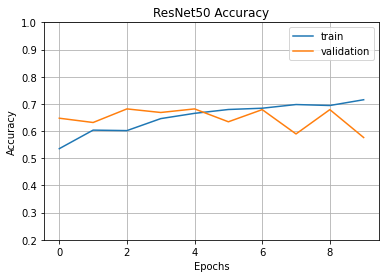

In [8]:
history = ResNet50_history
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
fig1 = plt.gcf()
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.axis(ymin=0.2,ymax=1)
plt.grid()
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])